라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 1
model_name = ['Test230724_tank1_lstm_only-feed_no180', 'Test230721_tank1_lstm_crop720_only-feed']

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [3]:
#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")

In [4]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [5]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_validation_sensor_val_tb = japonica_validation_sensor_val[japonica_validation_sensor_val['tank_id']==tank]

#시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

#중복 시간 제거
#japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb.drop_duplicates(subset=["mea_dt"])

# 시계열 데이터의 개수 확인
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)

/tmp/ipykernel_1743976/52306410.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
/tmp/ipykernel_1743976/52306410.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
/tmp/ipykernel_1743976/52306410.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [6]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

#문제 날짜 삭제
date_to_remove = pd.to_datetime('2021-08-03')
japonica_validation_data = japonica_validation_data.drop(japonica_validation_data[japonica_validation_data.index.date == date_to_remove.date()].index)

In [7]:
japonica_validation_features_X_a = japonica_validation_data[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_features_X_b = japonica_validation_data[['feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [8]:
m = load_model(model_name[1]+'.h5', custom_objects={'r_squared': r_squared})

array_length = 720
X_pred3_array = np.zeros(720)
X_pred3_array[270] = 7.4
X_pred3_array = X_pred3_array.reshape((-1, 720, 1))
X_pred3 = m.predict(X_pred3_array)
X_pred3 = np.asarray(X_pred3, dtype=np.float64)
X_pred3 = X_pred3.reshape((-1))

X_pred3

2023-07-24 08:19:00.002811: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 08:19:00.491916: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0
2023-07-24 08:19:01.173161: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-07-24 08:19:03.084192: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2023-07-24 08:19:04.238808: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the 

array([8.87132645, 8.89298153, 8.90080738, 8.88353443, 8.87759686,
       8.88585472, 8.88856602, 8.91648293, 8.91856289, 8.91822338,
       8.8909483 , 8.88341618, 8.88745308, 8.8920536 , 8.91163445,
       8.91731262, 8.91665173, 8.88782978, 8.87568855, 8.88899708,
       8.94584942, 8.94092846, 8.95466423, 8.92726994, 8.92988396,
       8.91373158, 8.91718292, 8.93421268, 8.93392372, 8.9207468 ,
       8.90833664, 8.89165783, 8.91162682, 8.93556499, 8.9388752 ,
       8.93703747, 8.9262886 , 8.93266582, 8.92859554, 8.9620018 ,
       8.97819996, 8.94496441, 8.93922806, 8.93177223, 8.91521645,
       8.96240711, 8.94705868, 8.97790909, 8.95730591, 8.94349957,
       8.92640781, 8.93534184, 8.94489288, 8.98079491, 8.97489452,
       8.97537327, 8.96856499, 8.97263145, 8.97898579, 9.02833462,
       9.00623989, 9.01737213, 8.99316311, 9.011343  , 8.9746809 ,
       9.00203419, 8.99991608, 8.96551704, 8.98224258, 8.98204327,
       8.99606895, 8.9926548 , 9.01067066, 8.99786758, 9.01650

모델 평가

In [9]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('x')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)
    
def grapeNEva4(y_test, X_test_shape, y_test_shape, feed):
    X_pred = []
    model = []
    array_index = 0
    
    for i in range(len(model_name)):
        model.append(load_model(model_name[i]+'.h5', custom_objects={'r_squared': r_squared}))
    
    ones_array = np.ones(len(feed))
    
    for i in range(len(feed)):
        if feed[i] > 0 :
            array_index = i
            X_pred2_array = np.asarray(feed[i])
            X_pred2_array = X_pred2_array.reshape((-1, 1, 1))
            X_pred2 = model[0].predict(X_pred2_array)
            X_pred2 = np.asarray(X_pred2, dtype=np.float64)
            X_pred2 = X_pred2.reshape((-1)) / 8.50096798
            
            array_length = 720
            X_pred3_array = np.zeros(720)
            X_pred3_array[270] = feed[i]
            X_pred3_array = X_pred3_array.reshape((-1, 720, 1))
            X_pred3 = model[1].predict(X_pred3_array)
            X_pred3 = np.asarray(X_pred3, dtype=np.float64)
            X_pred3 = X_pred3.reshape((-1)) / 8.50096798
            
            X_pred4 = X_pred3 * X_pred2
            
            x = 0
            if array_index < 270 :
                x = 270 - array_index
                X_pred4 = X_pred4[x:]
            
            ones_array[array_index+x-270:array_index-270+x+len(X_pred4)] = ones_array[array_index+x-270:array_index-270+x+len(X_pred4)] * X_pred4

        

#         # 그래프 생성
#         plt.figure(figsize=(15, 7))
#         plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
#         plt.plot(y_test.index, X_pred[i], color='red', label='prediction do')  # x축에 년월일, y축에 시분
#         plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
#         plt.xlabel('date')
#         plt.ylabel('do')
#         plt.title(model_name[i])
#         plt.legend(['sensor do','prediction do','feed_quantity'])
#         plt.show()
    
#         # 평가 생성
#         result = model[i].evaluate(X_test_shape[i], y_test_shape[i])
#         print("MSE // MAE // R-squared ", result)
    
    
#     final_predictions = (X_pred[0] / 8.50096798) * X_pred[1]
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, ones_array, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('multi')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()

nCar: 61740 nVar: 1
nCar: 61740 nVar: 1
nCar: 61740 nVar: 1
nCar: 61740 nVar: 1
nCar: 61740 nVar: 1


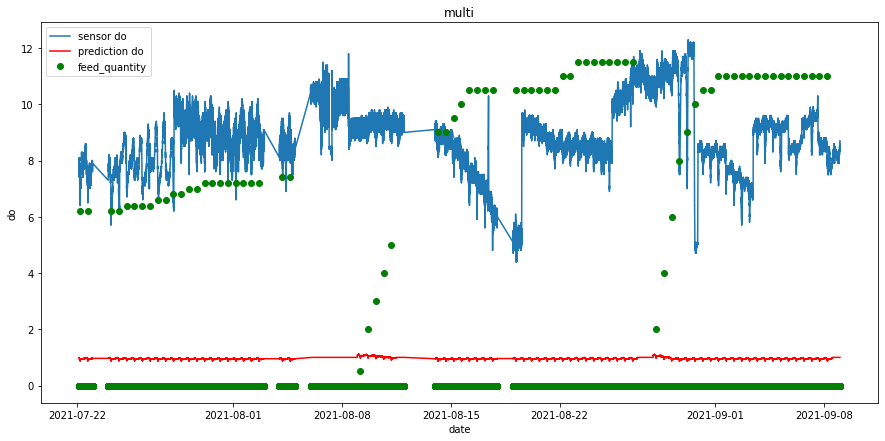

In [10]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-09-08 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape2 = y_test_reshape.reshape((-1, 1, 1))


nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape2.shape[0] # 데이터 개수
nVar = y_test_reshape2.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )



y_test_shape = [y_test_reshape2]

X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-09-08 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test_shape =[X_test_reshape2]

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

# shape확인
nCar = feed.shape[0] # 데이터 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva4(y_test, X_test_shape, y_test_shape, feed)

nCar: 12780 nVar: 1
nCar: 12780 nVar: 1
nCar: 18 nVar: 720
nCar: 12780 nVar: 1
nCar: 12780 nVar: 1
nCar: 18 nVar: 1
nCar: 18 nVar: 1
nCar: 12780 nVar: 1


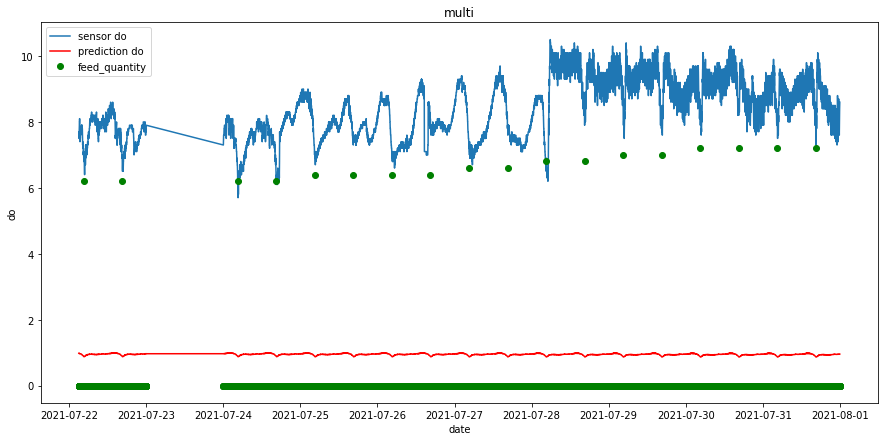

In [11]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-07-31 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape2 = y_test_reshape.reshape((-1, 1, 1))

zero_padding = np.zeros((180, 1), dtype=np.float64)
y_test_reshape3 = np.concatenate([zero_padding, y_test_reshape], axis=0)
y_test_reshape3 = y_test_reshape3.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape2.shape[0] # 데이터 개수
nVar = y_test_reshape2.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape3.shape[0] # 데이터 개수
nVar = y_test_reshape3.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

y_test_shape = [y_test_reshape2, y_test_reshape3]

X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-31 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test3 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-31 23:59']

X_test_reshape3 = np.asarray(X_test3, dtype=np.float64)
zero_padding = np.zeros((180, 1), dtype=np.float64)
X_test_reshape3 = np.concatenate([zero_padding, X_test_reshape3], axis=0)
X_test_reshape3 = X_test_reshape3.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test_shape =[X_test_reshape2, X_test_reshape3]

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

# shape확인
nCar = feed.shape[0] # 데이터 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva4(y_test, X_test_shape, y_test_shape, feed)

nCar: 1260 nVar: 1
nCar: 1260 nVar: 1
nCar: 2 nVar: 720
nCar: 1260 nVar: 1
nCar: 1260 nVar: 1
nCar: 2 nVar: 1
nCar: 2 nVar: 1
nCar: 1260 nVar: 1


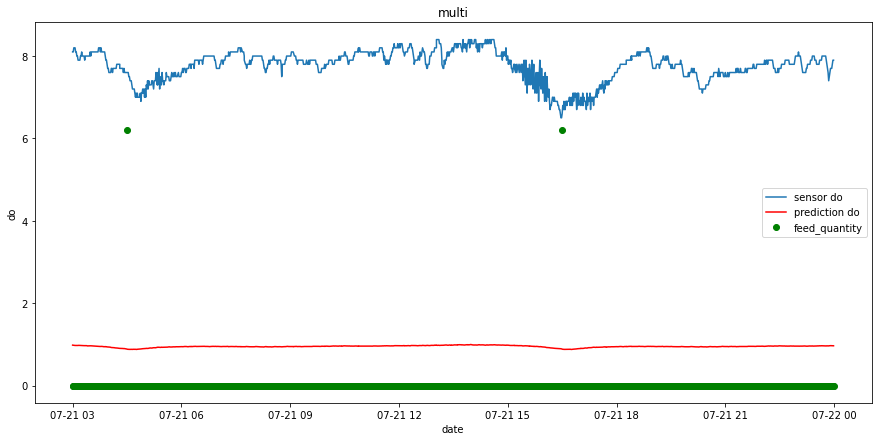

In [12]:
y_date = japonica_validation_features_y.loc['2021-07-21 03:00':'2021-07-21 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape2 = y_test_reshape.reshape((-1, 1, 1))

zero_padding = np.zeros((180, 1), dtype=np.float64)
y_test_reshape3 = np.concatenate([zero_padding, y_test_reshape], axis=0)
y_test_reshape3 = y_test_reshape3.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape2.shape[0] # 데이터 개수
nVar = y_test_reshape2.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape3.shape[0] # 데이터 개수
nVar = y_test_reshape3.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

y_test_shape = [y_test_reshape2, y_test_reshape3]

X_test2 = japonica_validation_features_X_b.loc['2021-07-21 03:00':'2021-07-21 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test3 = japonica_validation_features_X_b.loc['2021-07-21 03:00':'2021-07-21 23:59']

X_test_reshape3 = np.asarray(X_test3, dtype=np.float64)
zero_padding = np.zeros((180, 1), dtype=np.float64)
X_test_reshape3 = np.concatenate([zero_padding, X_test_reshape3], axis=0)
X_test_reshape3 = X_test_reshape3.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test_shape =[X_test_reshape2, X_test_reshape3]

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

# shape확인
nCar = feed.shape[0] # 데이터 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva4(y_test, X_test_shape, y_test_shape, feed)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


nCar: 1260 nVar: 1
nCar: 1260 nVar: 1
nCar: 2 nVar: 720
nCar: 1260 nVar: 1
nCar: 1260 nVar: 1
nCar: 2 nVar: 1
nCar: 2 nVar: 1
nCar: 1260 nVar: 1


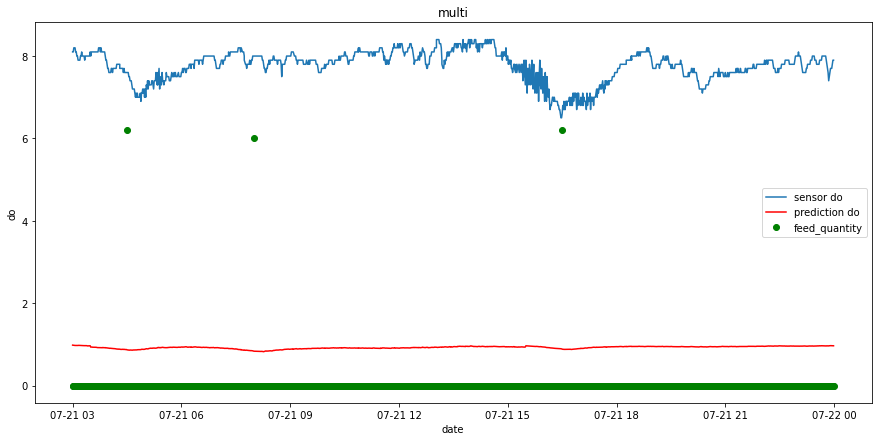

In [13]:
japonica_validation_features_X_b.at['2021-07-21 08:00', 'feed_quantity'] = 6
y_date = japonica_validation_features_y.loc['2021-07-21 03:00':'2021-07-21 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape2 = y_test_reshape.reshape((-1, 1, 1))

zero_padding = np.zeros((180, 1), dtype=np.float64)
y_test_reshape3 = np.concatenate([zero_padding, y_test_reshape], axis=0)
y_test_reshape3 = y_test_reshape3.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape2.shape[0] # 데이터 개수
nVar = y_test_reshape2.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape3.shape[0] # 데이터 개수
nVar = y_test_reshape3.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

y_test_shape = [y_test_reshape2, y_test_reshape3]

X_test2 = japonica_validation_features_X_b.loc['2021-07-21 03:00':'2021-07-21 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test3 = japonica_validation_features_X_b.loc['2021-07-21 03:00':'2021-07-21 23:59']

X_test_reshape3 = np.asarray(X_test3, dtype=np.float64)
zero_padding = np.zeros((180, 1), dtype=np.float64)
X_test_reshape3 = np.concatenate([zero_padding, X_test_reshape3], axis=0)
X_test_reshape3 = X_test_reshape3.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test_shape =[X_test_reshape2, X_test_reshape3]

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

# shape확인
nCar = feed.shape[0] # 데이터 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva4(y_test, X_test_shape, y_test_shape, feed)